In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

In [183]:
#preprocessing

lnames = ['movie_id','imdb_id','tmdb_id']
links = pd.read_csv('ml-latest-small/links.csv', sep=',', header=None, names=lnames)

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-latest-small/ratings.csv', sep=',', header=None, names=rnames)

mnames = ['movie_id', 'title', 'genres']
movies = pd.read_csv('ml-latest-small/movies.csv', sep=',', header=None, names=mnames)

In [3]:
data = pd.merge(pd.merge(movies, ratings), links)
data = data.drop([0])#first row is labels
data[:5]

,movie_id,title,genres,user_id,rating,timestamp,imdb_id,tmdb_id
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,0114709,862
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,0114709,862
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,0114709,862
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,0114709,862
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,0114709,862


In [135]:
#Each movie average rating
data['rating'] = data['rating'].astype(float)
data['timestamp'] = data['timestamp'].astype(int)
mean_ratings = data.pivot_table(values='rating', index='title', aggfunc='mean')
mean_ratings

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


In [136]:
#Highest rated movies
top_movies = mean_ratings.sort_values(['rating'], ascending=False)
top_movies[:10]

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


In [137]:
#removing outliers 
ratings_by_title = data.groupby('movie_id').size()
ratings_by_title = pd.DataFrame(ratings_by_title, columns = ['n_ratings'])
ratings_by_title = pd.merge(ratings_by_title, movies, on='movie_id')
ratings_by_title = ratings_by_title.drop(columns=['movie_id','genres'])
ratings_by_title = ratings_by_title.set_index('title')
ratings_by_title['n_ratings'] = ratings_by_title['n_ratings'].astype(int)
ratings_by_title

,n_ratings
title,
Toy Story (1995),215
GoldenEye (1995),132
City Hall (1996),14
Human Planet (2011),1
Comme un chef (2012),1
...,...
Codependent Lesbian Space Alien Seeks Same (2011),1
2 Days in the Valley (1996),12
"Last Stand, The (2013)",2


In [138]:
#titles with atleast 3% of the number of ratings as the most rated movie
min_ratings = max(ratings_by_title['n_ratings'])*0.1
min_ratings = int(min_ratings)
print("minimum number of ratings: "+str(min_ratings))
active_titles = ratings_by_title.index[ratings_by_title['n_ratings'] > min_ratings]
active_titles

minimum number of ratings: 32


Index(['Toy Story (1995)', 'GoldenEye (1995)', 'Cool Runnings (1993)',
       'Cinderella (1950)', 'Mary Poppins (1964)', 'Dumbo (1941)',
       'Alice in Wonderland (1951)', 'Sound of Music, The (1965)',
       'Die Hard (1988)', 'Happy Gilmore (1996)',
       ...
       'Gone with the Wind (1939)', 'Intouchables (2011)',
       'Citizen Kane (1941)', '2001: A Space Odyssey (1968)',
       'Broken Arrow (1996)', 'It's a Wonderful Life (1946)', 'Skyfall (2012)',
       'African Queen, The (1951)',
       'Hobbit: An Unexpected Journey, The (2012)', 'Django Unchained (2012)'],
      dtype='object', name='title', length=806)

In [148]:
#Highest rated movies with enough ratings to qualify
mean_ratings = mean_ratings.loc[active_titles]
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
mean_ratings

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
Lawrence of Arabia (1962),4.300000
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
...,...
"Flintstones, The (1994)",2.357143
Hollow Man (2000),2.294872
Batman & Robin (1997),2.214286


In [10]:
data['user_id'] = data['user_id'].astype(str).astype(int)
sorted_by_user = data.sort_values(by = 'user_id')
sorted_by_user

,movie_id,title,genres,user_id,rating,timestamp,imdb_id,tmdb_id
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,0114709,862
35549,1777,"Wedding Singer, The (1998)",Comedy|Romance,1,4.0,964981230,0120888,11003
35250,1732,"Big Lebowski, The (1998)",Comedy|Crime,1,5.0,964981125,0118715,115
34349,1676,Starship Troopers (1997),Action|Sci-Fi,1,3.0,964982620,0120201,563
2380,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1,5.0,964982931,0114814,629
...,...,...,...,...,...,...,...,...
71057,6387,Once a Thief (Zong heng si hai) (1991),Action|Comedy|Crime|Thriller,610,3.5,1479542038,0101020,47423
87455,59915,Stuck (2007),Horror|Thriller,610,3.5,1493848708,0758786,13848
97037,111663,Zombeavers (2014),Action|Comedy|Horror,610,3.5,1493848822,2784512,254474
98182,122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX,610,4.5,1479544589,2488496,140607


In [11]:
#Data Encoding: each user and their movie ratings
n_users = data.user_id.unique().shape[0]
print(n_users, ' users')
n_movies = data.movie_id.unique().shape[0]
print(n_movies, ' movies')
ratings_matrix = sorted_by_user.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
ratings_matrix

610  users
9724  movies


movie_id,1,10,100,100044,100068,100083,100106,100159,100163,100194,...,99750,99764,998,99813,99846,99853,999,99910,99917,99992
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
R = np.array(ratings_matrix)
sparsity = float(len(R.nonzero()[0]))
sparsity /= (R.shape[0] * R.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 1.70%


In [17]:
#Train and test matrix fact. adapted from towardsdatascience
def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0]) > 0:#every user that has rated a movie
            val_ratings = np.random.choice(
                ratings[user, :].nonzero()[0], 
                size=3,#remove 3 ratings
                replace=False
            )
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    return train, validation

In [23]:
train, val = train_test_split(R)

train

array([[4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 4. , 0. , ..., 0. , 0. , 0. ],
       [3. , 4. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 3. , 0. ]], dtype=float32)

In [66]:
def rmse(prediction, actual_rating):
    prediction = prediction[actual_rating.nonzero()].flatten() 
    actual_rating = actual_rating[actual_rating.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, actual_rating))

In [50]:
def predict(X_train, X_val, n_iters=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    m, n = X_train.shape

    P = 3 * np.random.rand(n_latent_features, m)
    Q = 3 * np.random.rand(n_latent_features, n)
    
    train_error = []
    val_error = []

    users, movies = X_train.nonzero()
    
    for epoch in range(n_iters):
        for u, i in zip(users, movies):
            error = X_train[u, i] -  np.dot(P[:,u],  Q[:,i])
            P[:, u] +=  learning_rate * (error *  Q[:, i] -  lmbda *  P[:, u])
            Q[:, i] +=  learning_rate * (error *  P[:, u] -  lmbda *  Q[:, i])

        train_rmse = rmse(np.dot(P.T, Q), X_train)
        val_rmse = rmse(np.dot(P.T, Q), X_val)
        train_error.append(train_rmse)
        val_error.append(val_rmse)
        
    return np.dot(P.T, Q) , train_error, val_error

In [166]:
prediction, t_err, v_err = predict(train, val)

prediction.shape

(610, 9724)

In [67]:
err = rmse(prediction, R)
print(err)

0.8358104478226517


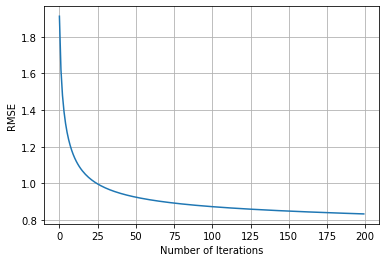

In [155]:
plt.plot(range(200), t_err)
plt.xlabel('Number of Iterations');
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [167]:
prediction = pd.DataFrame(data = prediction, index = ratings_matrix.index, columns =ratings_matrix.columns)

prediction

movie_id,1,10,100,100044,100068,100083,100106,100159,100163,100194,...,99750,99764,998,99813,99846,99853,999,99910,99917,99992
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.580596,4.035502,3.302752,4.929566,7.036121,4.275276,4.757611,5.689155,3.842702,5.024692,...,5.018598,7.270317,3.701338,4.994035,5.576909,4.854845,3.750072,3.427114,4.836828,3.652521
2,3.733935,3.252347,2.724211,4.348223,5.566487,3.932958,3.818701,5.623124,3.102758,4.496805,...,4.359343,6.095659,4.077150,4.445954,5.455352,3.772453,3.950846,3.307468,3.838082,2.997262
3,2.705491,2.383145,1.742172,2.778362,4.313925,2.303587,2.498707,2.661990,2.331361,2.660119,...,2.708793,4.207469,1.038735,2.787078,2.733242,2.947969,1.215538,1.385409,2.762927,2.015436
4,3.475563,3.014935,2.373222,4.043566,5.257632,3.622031,3.277270,4.974086,2.929588,4.060313,...,3.932843,5.656729,3.187001,4.124811,4.907230,3.518290,3.138402,2.715450,3.460847,2.678721
5,3.696492,3.276773,2.872315,3.946329,5.597967,3.450558,4.205203,4.818380,3.050500,4.172728,...,4.181922,5.870468,3.657076,4.005933,4.620539,3.929476,3.625486,3.179157,4.059620,3.089378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.607039,3.176138,2.630043,3.914768,5.511826,3.416741,3.785170,4.618361,3.016392,4.016183,...,3.998323,5.744422,3.116296,3.971526,4.508137,3.803762,3.127312,2.807462,3.816503,2.896034
607,4.005740,3.591771,3.139638,3.955246,6.204325,3.315051,4.714613,4.350762,3.319838,4.174685,...,4.314063,6.202285,3.144306,3.979136,4.178952,4.436733,3.247737,3.072781,4.541705,3.368257
608,3.572602,3.179366,2.794295,3.723034,5.444605,3.216904,4.127075,4.426386,2.949575,3.942393,...,3.988020,5.629564,3.341420,3.769709,4.241466,3.848055,3.345520,2.990427,3.971300,2.998868


In [151]:
#highest rated predictions
highest_prediction = prediction.mean(axis=0)
highest_prediction = pd.DataFrame(data = highest_prediction,index = ratings_matrix.columns, columns = ['predicted_rating'])
highest_prediction = pd.merge(highest_prediction, movies, on='movie_id')
highest_prediction = highest_prediction.set_index(['title'])
highest_prediction = highest_prediction.sort_values(by = 'predicted_rating', ascending = False)
highest_prediction

,movie_id,predicted_rating,genres
title,,,
Renaissance (2006),44849,6.788698,Action|Animation|Film-Noir|Sci-Fi|Thriller
Stuart Little 3: Call of the Wild (2005),121781,6.774725,Animation|Children|Comedy|Fantasy
Man on the Flying Trapeze (1935),67888,6.671108,Comedy
World of Glory (1991),158398,6.669675,Comedy
Idlewild (2006),47646,6.540420,Crime|Drama|Musical
...,...,...,...
Skyline (2010),82095,1.202360,Sci-Fi|Thriller
Police Academy: Mission to Moscow (1994),8387,1.151890,Comedy|Crime
Contact High (2009),92046,1.124166,Comedy


In [152]:
highest_prediction = highest_prediction.drop(columns = ['genres','movie_id'])
highest_prediction = highest_prediction.loc[active_titles]
highest_prediction = highest_prediction.sort_values(by = 'predicted_rating', ascending = False)
highest_prediction[:25]

,predicted_rating
title,
War of the Worlds (2005),5.062200
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.304641
Patton (1970),4.295638
Lawrence of Arabia (1962),4.288524
Rear Window (1954),4.262609
"Shawshank Redemption, The (1994)",4.238524
Fight Club (1999),4.183963
"Godfather, The (1972)",4.176110
Cool Hand Luke (1967),4.172344


In [149]:
mean_ratings[:25]

,rating
title,
"Shawshank Redemption, The (1994)",4.429022
Lawrence of Arabia (1962),4.300000
"Godfather, The (1972)",4.289062
Fight Club (1999),4.272936
Cool Hand Luke (1967),4.271930
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041
Rear Window (1954),4.261905
"Godfather: Part II, The (1974)",4.259690
"Departed, The (2006)",4.252336


In [159]:
ratings_comparison = mean_ratings.merge(highest_prediction, on='title', how='left')
ratings_comparison['%_diff'] = ((ratings_comparison['rating'] - ratings_comparison['predicted_rating'])/ratings_comparison['rating'])*100
ratings_comparison

,rating,predicted_rating,%_diff
title,,,
"Shawshank Redemption, The (1994)",4.429022,4.238524,4.301140
Lawrence of Arabia (1962),4.300000,4.288524,0.266881
"Godfather, The (1972)",4.289062,4.176110,2.633497
Fight Club (1999),4.272936,4.183963,2.082240
Cool Hand Luke (1967),4.271930,4.172344,2.331160
...,...,...,...
"Flintstones, The (1994)",2.357143,2.387099,-1.270863
Hollow Man (2000),2.294872,2.413130,-5.153159
Batman & Robin (1997),2.214286,2.187798,1.196220


In [189]:
user_recommendation = prediction.idxmax(axis="columns")
user_recommendation = pd.DataFrame(user_recommendation, index = ratings_matrix.index, columns=['movie_id'])
user_recommendation

,movie_id
user_id,
1,92494
2,92494
3,8238
4,92494
5,92494
...,...
606,92494
607,92494
608,92494


In [190]:
user_recommendation = user_recommendation.merge(movies, on=['movie_id'], how='left')
user_recommendation = user_recommendation.drop(columns = 'genres')
user_recommendation.index = ratings_matrix.index
user_recommendation

,movie_id,title
user_id,,
1,92494,Dylan Moran: Monster (2004)
2,92494,Dylan Moran: Monster (2004)
3,8238,Little Murders (1971)
4,92494,Dylan Moran: Monster (2004)
5,92494,Dylan Moran: Monster (2004)
...,...,...
606,92494,Dylan Moran: Monster (2004)
607,92494,Dylan Moran: Monster (2004)
608,92494,Dylan Moran: Monster (2004)


In [191]:
recommended = user_recommendation.groupby('title').size()
recommended

title
Asterix and the Vikings (Astérix et les Vikings) (2006)      3
Chump at Oxford, A (1940)                                    1
Coriolanus (2011)                                           13
Dark Passage (1947)                                          2
Dylan Moran: Monster (2004)                                522
Hunting Elephants (2013)                                     1
Little Murders (1971)                                       16
Patton Oswalt: My Weakness Is Strong (2009)                  8
Rebound, The (2009)                                          1
Smiley's People (1982)                                       1
Valet, The (La doublure) (2006)                             18
Who Killed Chea Vichea? (2010)                              24
dtype: int64